# GAN
We want to use the same dataset as we have used MINST Handwritten dataset.
### MINST Dataset

La base de données MNIST (Modified National Institute of Standards and Technology) est une vaste collection de chiffres manuscrits. Elle comprend un ensemble d'entraînement de 60 000 exemples et un ensemble de test de 10 000 exemples. Il s'agit d'un sous-ensemble de la base de données spéciale NIST 3 (chiffres écrits par des employés du Bureau du recensement des États-Unis) et de la base de données spéciale NIST 1 (chiffres écrits par des lycéens), qui contiennent des images monochromes de chiffres manuscrits. Les chiffres ont été normalisés en taille et centrés dans une image de taille fixe. Les images noir et blanc (bichromes) d'origine de la NIST ont été normalisées en taille pour s'adapter à une boîte de 20x20 pixels tout en préservant leur rapport hauteur/largeur. Les images résultantes contiennent des niveaux de gris en raison de la technique d'anti-aliasing utilisée par l'algorithme de normalisation. Les images ont été centrées dans une image de 28x28 en calculant le centre de masse des pixels, puis en déplaçant l'image de manière à positionner ce point au centre du champ de 28x28 pixels.

![](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)
# Importer des bibliothèques

In [17]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape


## Importer l'ensemble de données MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

## Explorer les données

train_images.shape (60000, 28, 28)


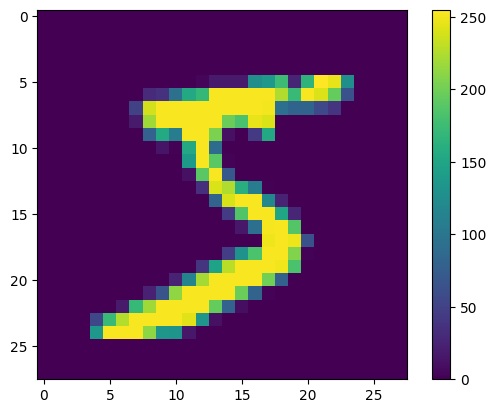

In [3]:
print('train_images.shape',X_train.shape)

plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()


## Prétraitement des données

In [4]:
X_train = X_train / 255.0

Pour vérifier que les données sont dans le format correct et que vous êtes prêt à construire et entraîner le réseau, affichons les 20 premières images de l'*ensemble d'entraînement* et affichons le nom de classe sous chaque image.

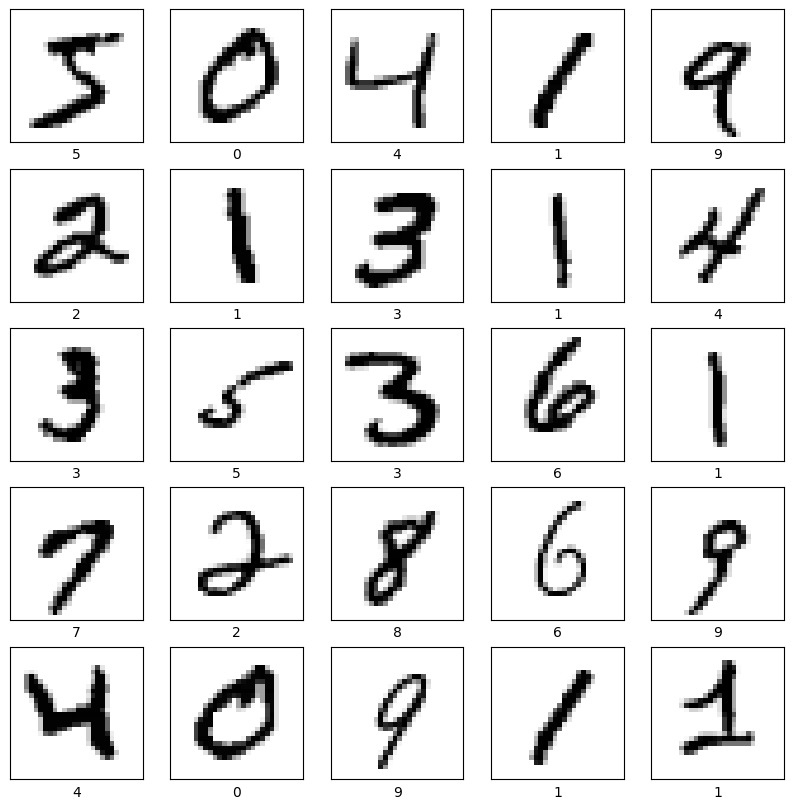

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## Construction du modèle

### Discriminator
This is similar model as we have created last weeks. I do not go into details of the model as it needs deeper knoweldge but always consider that the model is given to you.

In [9]:
discriminator = Sequential(name="discriminator")
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))



discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)             

### Generator

In [10]:
generator = Sequential(name="generator")
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))


generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               51712     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                        

Now We are going to create our simple GAN network
![](https://developer.ibm.com/developer/default/articles/generative-adversarial-networks-explained/images/GANs.jpg)

In [11]:
GAN =Sequential([generator,discriminator])
GAN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 28, 28, 1)         320656    
                                                                 
 discriminator (Sequential)  (None, 1)                 242179    
                                                                 
Total params: 562835 (2.15 MB)
Trainable params: 561043 (2.14 MB)
Non-trainable params: 1792 (7.00 KB)
_________________________________________________________________


### Compiler les modèles

#### Compiler discriminator

In [12]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

#### Compiler generator
⚠️ We do not need to compile generator alone! instead we can compile whole GAN network together by telling the network that you should not train the discriminator part.  It is exactly the same but is easier to train since we have both parts together.

In [13]:
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

## Entraîner le modèle

The training phase at each step, contains two parts: training the discriminator, then fixing the discriminator and training the generator

let's go:


Before starting, for ease of displaying, we want to use tqdm library to show the progress of the training.
add `from tqdm.auto import tqdm`
and then in any place that you want to show progress bar, you can wrap with `tqdm()`

for eample instead of `range(10)` you can use `tqdm(range(10))`

epochs:   0%|          | 0/30 [00:00<?, ?it/s]

batchs in epoch 0:   0%|          | 0/600 [00:00<?, ?it/s]

2024-03-27 22:01:59.221158: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 13ms/step


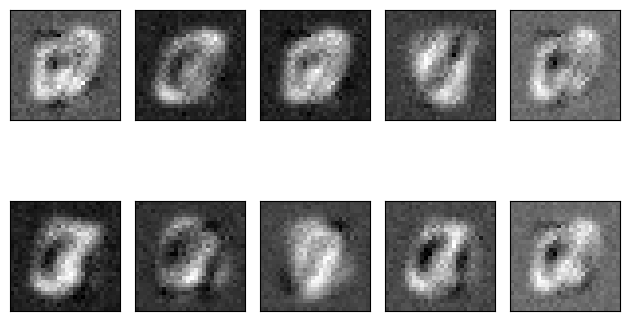

batchs in epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
epochs = 30
batch_size = 100
noise_shape=100

for epoch in tqdm(range(epochs),desc="epochs"):   
    for i in tqdm(range(X_train.shape[0]//batch_size),desc=f"batchs in epoch {epoch}"):
            
        random_input=np.random.normal(size=[batch_size,noise_shape]) # Generate random values
       
        fake_images = generator.predict_on_batch(random_input) # use the random values to generate new images
        
        real_train_dataset = X_train[i*batch_size:(i+1)*batch_size] # select a subset of dataset
       
        #training discriminator on real images
        real_train_label=np.ones(shape=(batch_size,1)) # all labels are 1 since all are real
        discriminator.trainable = True # Now we want train the discriminator
        d_loss_real=discriminator.train_on_batch(real_train_dataset,real_train_label)
        
        #training discriminator on fake images
        fake_train_label=np.zeros(shape=(batch_size,1)) # all fake images should be 0 in label why?
        d_loss_fake=discriminator.train_on_batch(fake_images,fake_train_label)
        
        ## Now we have trained discriminator let's go to train generator by fixing discriminator
        discriminator.trainable = False

        #training generator 
        random_input=np.random.normal(size=[batch_size,noise_shape])
        fooled_label=np.ones(shape=(batch_size,1))
        # why? because we want to train generator. our goal is to have all generated images classified as real image
        d_g_loss_batch =GAN.train_on_batch(random_input, fooled_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

# Display the input

Text(0.5, 1.0, 'How the input looks')

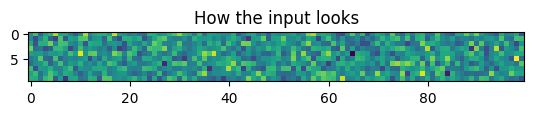

In [22]:
input=np.random.normal(size=[10,noise_shape])
plt.imshow(input)
plt.title('How the input looks')

# Display the generated images


1/1 [==============================] - 0s 23ms/step


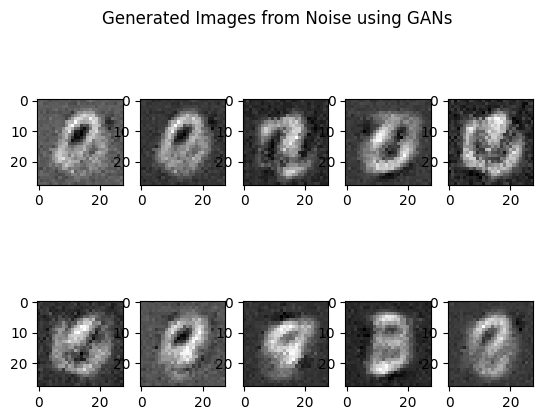

In [23]:
gen_image = generator.predict(input)


fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1